In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [6]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from numba import jit, njit
plt.style.use('/home/manu/TFG_repo/notebooks/notebook.mplstyle')

In [7]:
from analysis_functions import *

In [57]:
temp, pres, date, lat, lon = load_time_series('trial.h5')
df_n = load_SHDR_fit('trial_no_bias.csv')
df_b = load_SHDR_fit('trial_bias.csv')

In [13]:
print(f'Time series ranging from {df_n.iloc[0, 0]} to {df_n.iloc[-1, 0]}')

Time series ranging from 2019-12-07 10:50:04 to 2019-12-07 11:06:39


In [51]:
def penalty_f(z, a, c, MLD):
    #return a * np.exp(- (z - MLD / 4)**2 / 2 / c**2)
    pos = np.where(z<=MLD, 1, 0)
    return pos*a

def fitness(df, temp, pres, loc):
    ''' Get RMS for profile in loc at height z 
    ''' 

    if isinstance(loc, datetime):
        loc = date_to_iloc(df, loc)

    temp_loc = temp[:, loc]
    fitness = np.sqrt(np.sum((temp_loc - fit_function(pres, df, loc))**2/len(temp_loc)) / len(temp_loc))
    return fitness


def modified_fitness(df, temp, pres, loc, MLD, a, c,):
    ''' Modfied version to implement higher error weights to points in
    the MLD '''
    
    if isinstance(loc, datetime):
        loc = date_to_iloc(df, loc)
        
    alpha = fitness(df, temp, pres, loc)**2 * np.sqrt(len(pres)) \
            / np.sum(((temp[:, loc] - fit_function(pres, df, loc))**2 
            * penalty_f(pres, a, c, MLD)))

    mod_fitness = np.sqrt(np.sum(((temp[:, loc] - fit_function(pres, df, loc))**2)
              * (1 + alpha)) / len(pres))

    return mod_fitness, alpha


def plot_modified_fitness(df, temp, pres, loc, MLD, a, c):
    ''' Plot experimental profile and fit with diference between fit and profile,
    and square of that difference.
    '''

    if isinstance(loc, datetime):
        loc = date_to_iloc(df, loc)
    
    temp_loc = temp[:, loc]
    _, alpha = modified_fitness(df_fit, temp, pres, loc, MLD, a, c)
    print(df['em'][loc])
    delta = (temp_loc - fit_function(pres, df, loc))**2 * (1 + penalty_f(pres, a, c, MLD))
    zz = np.linspace(0, pres[-1] + 5, 300)
    fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize = (7.5, 3.75))
    
    ax1.scatter(temp[:, loc], pres, marker='o', fc='None', ec='tab:red', s=22)
    ax1.axhline(df.iloc[loc, 3], c='grey', ls='--') # plot MLD
    ax1.set_ylim(pres[-1] + 10, 0)
    ax1.set_xlim(9.5, 18)
    ax1.plot(fit_function(zz, df, loc), zz)
    ax1.set_xlabel('Temperature (ºC)')
    ax1.set_ylabel('Depth (mb)')
    
    ax2.plot(penalty_f(zz, a, c, MLD), zz)
    ax2.set_ylim(pres[-1] + 10, 0)   
    
    ax3.barh(pres, delta, height=2)
    ax3.set_xlabel('$\Delta^2$')
    ax3.set_ylim(pres[-1] + 10, 0)
    ax3.tick_params(left=False)
    fig.tight_layout()
    plt.show()

In [14]:
def find_em_series(df, temp, pres):
    MLD = np.array(df['D1'])
    SST = np.array(df['a1'])
    MLD_T = pres[:, None] <= MLD
    em = np.array([find_em_MLD(temp[MLD, loc], SST[loc]) for loc, MLD in enumerate(MLD_T.T)])
    return em

@jit(nopython=True)
def find_em_MLD(MLD_thermistors, SST):
    em = np.sqrt(np.sum(MLD_thermistors - SST)**2/len(MLD_thermistors))
    return em



In [58]:
em = find_em_series(df_n, temp, pres)
em_b = find_em_series(df_b, temp, pres)


0.13458181716371745 0.12900350518816428


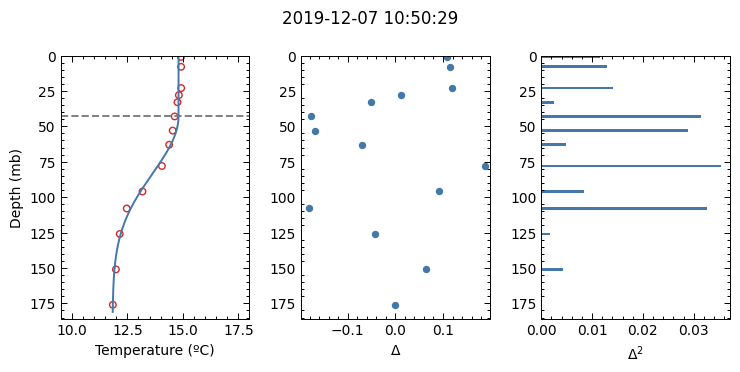

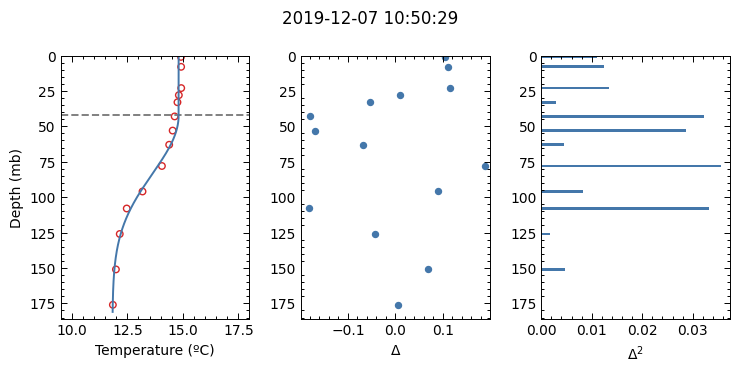

In [59]:
index = np.where(em > 0.1)[0]
n = -10
print(em[index[-10]], em_b[index[-10]])
plot_RMS_fit(df_n, temp, pres, index[-10])
plot_RMS_fit(df_b, temp, pres, index[-10])

0.1161284342795349


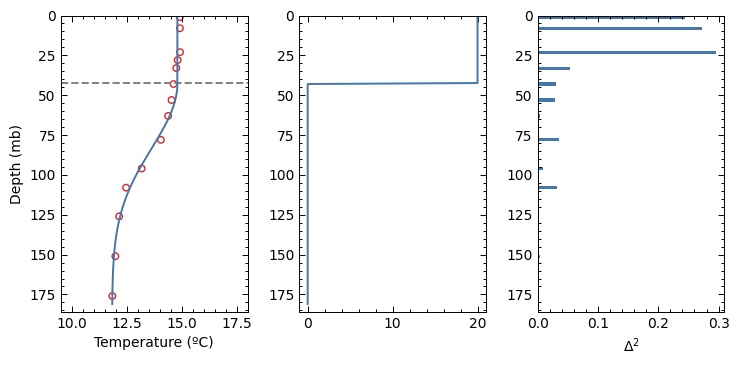

In [52]:
MLD = df_n['D1'][index[n]]
plot_modified_fitness(df_n, temp, pres, index[n], MLD, 20, MLD/6)